In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
# plt.ioff()
from matplotlib.animation import FuncAnimation
import json
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

BASEPATH = os.path.dirname(os.getcwd()).split('main')[0]
sys.path.append(BASEPATH)

from src.models import ScaledModel, WeightedMSELoss
from src.dataloader import AeroDataset
from src.plotting import create_grid

# set plt to inline
%matplotlib inline

DATAPATH = os.path.join(BASEPATH, 'data')
NETWORKPATH = os.path.join(DATAPATH, 'networks')
VISUPATH = os.path.join(DATAPATH, 'visualisation')


/tmp/ipykernel_29946/1849341607.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from numpy import polyfit

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
BATCH_SIZE = 256
EPOCHS = 200
PATIENCE = 2
LEARNING_RATE = 0.1
MOMENTUM = 0.7
SCALING = False
DATA_DIR = os.path.join(BASEPATH, 'data', 'processed')
MODEL_DIR = os.path.join(DATA_DIR, 'models')

num_workers = 0# if DEVICE == 'cpu' else 4

In [3]:
def prepare_datasets(scaling=False, input_features=None, output_features=None):
    if input_features is None:
        input_features = ['q','alpha','beta','ailerons','elevator']
    if output_features is None:
        output_features = ['CD', 'CY', 'CL', 'Cl', 'Cm', 'Cn']
    
    scaler, output_scaler = (StandardScaler(), StandardScaler()) if scaling else (None, None)
    dataset = AeroDataset(DATA_DIR, input_features, output_features, scaler, output_scaler)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return random_split(dataset, [train_size, test_size]), scaler, output_scaler

In [4]:

print(f'Using device: {DEVICE}')
input_features = ['q','alpha','beta','aileron','elevator']
output_features = ['CX', 'CY', 'CZ', 'Cl', 'Cm', 'Cn']
(train_dataset, test_dataset), scaler, output_scaler = prepare_datasets(SCALING, input_features, output_features)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# get input and output scales for normalization
inp_scaler = StandardScaler()
out_scaler = StandardScaler()

train_data = train_dataset.dataset.data
inp_scaler.fit(train_data[input_features].values)
out_scaler.fit(train_data[output_features].values)

scaler = (inp_scaler.mean_, inp_scaler.scale_, out_scaler.mean_, out_scaler.scale_)

Using device: cuda:0
         q     alpha      beta  aileron  elevator  windtunnel        CX  \
0  3001.25 -0.087266  0.174533      2.0       2.0        True -0.035789   
1  1531.25 -0.000000 -0.174533      5.0       5.0        True -0.044688   
2   551.25  0.174533 -0.174533      4.0       5.0        True -0.103120   
3  1531.25  0.087266  0.174533      2.0      -2.0        True -0.032957   
4  1531.25 -0.000000 -0.087266     -0.0       5.0        True -0.021606   

         CY        CZ        Cl        Cm        Cn  
0 -0.030805 -0.671510 -0.149844 -0.377175 -0.013971  
1  0.029719 -0.210403 -0.392142  0.007338  0.009220  
2  0.013397  0.619269 -0.158769  0.186966  0.011044  
3 -0.029023  0.388311 -0.170004  0.119393 -0.002237  
4  0.013401 -0.206011 -0.011117 -0.268361  0.003406  


/mnt/e/Github/AIrcraft/src/dataloader.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([dataset, temp[self.input_features + self.output_features]], axis=0)


In [5]:
train_data['Cm'].max()

0.595524550049502

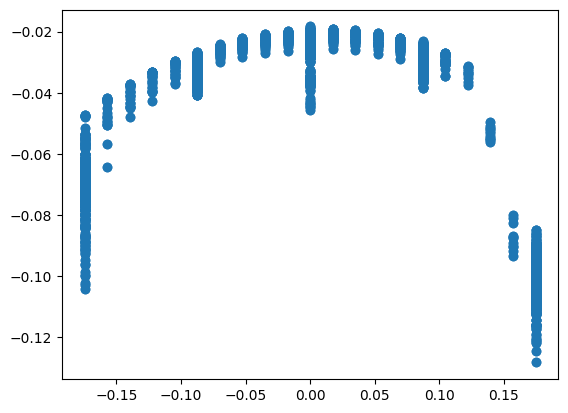

In [6]:
# plot of CX vs alpha

plt.scatter(train_data['alpha'], train_data['CX'])

/tmp/ipykernel_29946/2258213454.py:16: RankWarning: Polyfit may be poorly conditioned
  f.append(np.polyfit(X[i], Y - sum_func(f, X), 5))


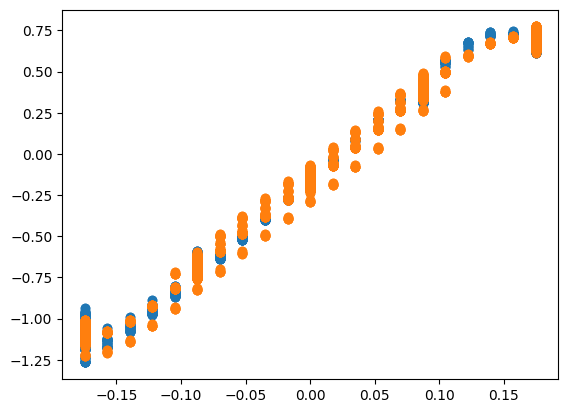

In [7]:
# fit drag with a 3rd order polynomial

X = train_data
Y = train_data['CZ']
f = []

def sum_func(f, x):
    res = 0
    for i, entry in enumerate(f):
        entry = np.poly1d(entry)
        res += entry(x[input_features[i]])

    return res

for i in input_features:
    f.append(np.polyfit(X[i], Y - sum_func(f, X), 5))

plt.scatter(X['alpha'], Y)
plt.scatter(X['alpha'], sum_func(f, X))

In [8]:
input_features

['q', 'alpha', 'beta', 'aileron', 'elevator']

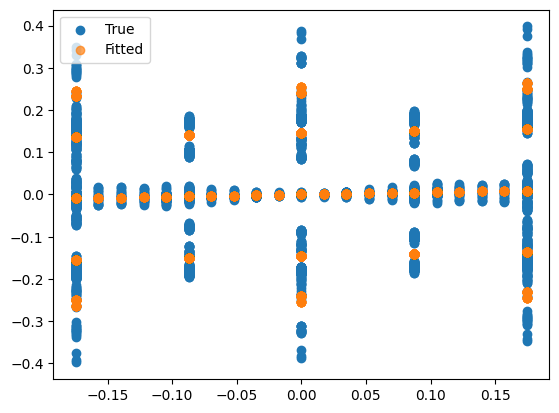

In [9]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
import pickle

# Assuming `train_data` is your DataFrame
X = train_data[input_features]  # Input features as a DataFrame
output_features = ['CX', 'CY', 'CZ', 'Cl', 'Cm', 'Cn']  # Outputs
poly_order = 3  # Polynomial order
fitted_models = {}

# Define symbolic variables for CasADi
casadi_vars = {feat: ca.MX.sym(feat) for feat in input_features}

def fit_polynomials(X, Y, input_features, poly_order):
    """Fits a polynomial model for each input feature."""
    f = []
    for i in input_features:
        residual = Y - sum_func(f, X)
        f.append(np.polyfit(X[i], residual, poly_order))
    return f

def sum_func(f, x):
    """Evaluates the sum of polynomial functions for the given input data."""
    res = 0
    for i, coeffs in enumerate(f):
        res += np.polyval(coeffs, x[input_features[i]])
    return res

def create_casadi_function(f, casadi_vars):
    """Creates a CasADi symbolic function from polynomial coefficients."""
    symbolic_expr = 0
    for i, coeffs in enumerate(f):
        poly_expr = sum(c * casadi_vars[input_features[i]]**(len(coeffs) - j - 
        1) 
                        for j, c in enumerate(coeffs))
        symbolic_expr += poly_expr
    return symbolic_expr

# Fit models and create CasADi functions
for output in output_features:
    Y = train_data[output]
    f = fit_polynomials(X, Y, input_features, poly_order)
    symbolic_expr = create_casadi_function(f, casadi_vars)
    casadi_func = ca.Function(output, [ca.vertcat(*casadi_vars.values())], [symbolic_expr])
    fitted_models[output] = {'coefficients': f, 'casadi_function': casadi_func}

# Save the CasADi functions and coefficients using pickle
with open('fitted_models_casadi.pkl', 'wb') as file:
    pickle.dump(fitted_models, file)

# Visualization for a specific output, e.g., 'CZ'
output_to_plot = 'Cl'
Y = train_data[output_to_plot]
f = fitted_models[output_to_plot]['coefficients']

plt.scatter(X['beta'], Y, label='True')
plt.scatter(X['beta'], sum_func(f, X), label='Fitted', alpha=0.7)
plt.legend()
plt.show()


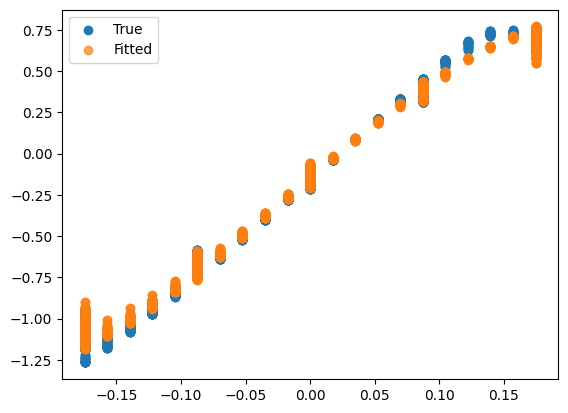

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

# Polynomial order
poly_order = 3

# Generate polynomial features (including interactions)
poly = PolynomialFeatures(degree=poly_order, include_bias=False)
X_poly = poly.fit_transform(X)  # X is the input DataFrame

# Fit the model for each output
fitted_models = {}
for output in output_features:
    Y = train_data[output]
    model = LinearRegression()
    model.fit(X_poly, Y)
    fitted_models[output] = {
        'model': model,
        'poly': poly,
        'coef': model.coef_,
        'intercept': model.intercept_,
    }

# Predict using the model
output_to_plot = 'CZ'
X_test = poly.transform(X)
Y_pred = fitted_models[output_to_plot]['model'].predict(X_test)

# Visualization
plt.scatter(X['alpha'], train_data[output_to_plot], label='True')
plt.scatter(X['alpha'], Y_pred, label='Fitted', alpha=0.7)
plt.legend()
plt.show()


In [11]:

# CasADi symbolic variables
casadi_vars = {feat: ca.MX.sym(feat) for feat in input_features}
casadi_input = ca.vertcat(*casadi_vars.values())

# Create CasADi symbolic functions
casadi_functions = {}
for output in output_features:
    coef = fitted_models[output]['coef']
    intercept = fitted_models[output]['intercept']
    
    # Generate polynomial terms with interactions
    terms = poly.get_feature_names_out(input_features)
    symbolic_expr = intercept
    for term, weight in zip(terms, coef):
        # Convert polynomial term (e.g., "alpha beta") to CasADi expression
        term_expr = ca.MX(1)
        print(term)
        for var in term.split(' '):  # Split terms like "alpha beta"
            print(var)
            if var in casadi_vars:
                term_expr *= casadi_vars[var]
                # print(term_expr)
            else:
                print('what')
        symbolic_expr += weight * term_expr

    # Create CasADi function
    casadi_func = ca.Function(output, [casadi_input], [symbolic_expr])
    casadi_functions[output] = casadi_func

# Save the fitted models and CasADi functions
with open('fitted_models_casadi.pkl', 'wb') as file:
    pickle.dump({'fitted_models': fitted_models, 'casadi_function': casadi_functions}, file)

q
q
alpha
alpha
beta
beta
aileron
aileron
elevator
elevator
q^2
q^2
what
q alpha
q
alpha
q beta
q
beta
q aileron
q
aileron
q elevator
q
elevator
alpha^2
alpha^2
what
alpha beta
alpha
beta
alpha aileron
alpha
aileron
alpha elevator
alpha
elevator
beta^2
beta^2
what
beta aileron
beta
aileron
beta elevator
beta
elevator
aileron^2
aileron^2
what
aileron elevator
aileron
elevator
elevator^2
elevator^2
what
q^3
q^3
what
q^2 alpha
q^2
what
alpha
q^2 beta
q^2
what
beta
q^2 aileron
q^2
what
aileron
q^2 elevator
q^2
what
elevator
q alpha^2
q
alpha^2
what
q alpha beta
q
alpha
beta
q alpha aileron
q
alpha
aileron
q alpha elevator
q
alpha
elevator
q beta^2
q
beta^2
what
q beta aileron
q
beta
aileron
q beta elevator
q
beta
elevator
q aileron^2
q
aileron^2
what
q aileron elevator
q
aileron
elevator
q elevator^2
q
elevator^2
what
alpha^3
alpha^3
what
alpha^2 beta
alpha^2
what
beta
alpha^2 aileron
alpha^2
what
aileron
alpha^2 elevator
alpha^2
what
elevator
alpha beta^2
alpha
beta^2
what
alpha beta aile

In [12]:
casadi_functions['CX']

Function(CX:(i0[5])->(o0) MXFunction)

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# Set range of polynomial degrees to test
degree_range = range(1, 6)  # Test degrees 1 to 5
best_degree = {}
scores = {}

for output in output_features:
    Y = train_data[output].values
    X = train_data[input_features].values
    
    best_score = float('inf')
    for degree in degree_range:
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly = poly.fit_transform(X)
        
        # Perform cross-validation
        model = LinearRegression()
        neg_mse = cross_val_score(model, X_poly, Y, cv=5, scoring='neg_mean_squared_error')
        mse = -neg_mse.mean()  # Take the mean of the negative MSE
        
        # Update the best degree if a lower MSE is found
        if mse < best_score:
            best_score = mse
            scores[degree] = best_score
            best_degree[output] = degree

# Output the best degree for each output feature
for output in best_degree:
    print(f"Best degree for {output}: {best_degree[output]}")


Best degree for CX: 3
Best degree for CY: 3
Best degree for CZ: 3
Best degree for Cl: 3
Best degree for Cm: 3
Best degree for Cn: 3


In [14]:
import casadi as ca
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import pickle
import matplotlib.pyplot as plt

# Assume train_data is already defined with input_features and output_features
input_features = ['q', 'alpha', 'beta', 'aileron', 'elevator']
output_features = ['CX', 'CY', 'CZ', 'Cl', 'Cm', 'Cn']
poly_order = 3  # Polynomial order

# Polynomial feature generation
poly = PolynomialFeatures(degree=poly_order, include_bias=False)
X = train_data[input_features].values
X_poly = poly.fit_transform(X)

# Fit multivariate polynomial models for each output
fitted_models = {}
for output in output_features:
    Y = train_data[output].values
    model = LinearRegression()
    model.fit(X_poly, Y)
    fitted_models[output] = {
        'model': model,
        'poly': poly,
        'coef': model.coef_,
        'intercept': model.intercept_,
    }

# CasADi symbolic variables
casadi_vars = {feat: ca.MX.sym(feat) for feat in input_features}
casadi_input = ca.vertcat(*casadi_vars.values())

# Create CasADi symbolic functions
casadi_functions = {}
for output in output_features:
    coef = fitted_models[output]['coef']
    intercept = fitted_models[output]['intercept']
    
    # Generate polynomial terms with interactions
    terms = poly.get_feature_names_out(input_features)  # e.g., ['q', 'q^2', 'alpha beta']
    symbolic_expr = intercept
    for term, weight in zip(terms, coef):

        # if abs(weight) < 1e-10:  # Suppress terms below the threshold
        #     continue
        # Parse polynomial terms into CasADi expressions
        term_expr = 1
        for var_power in term.split(' '):  # Split terms like "alpha^2 beta"
            if '^' in var_power:
                var, power = var_power.split('^')
                term_expr *= casadi_vars[var] ** int(power)
            elif var_power in casadi_vars:
                term_expr *= casadi_vars[var_power]
        symbolic_expr += weight * term_expr

    # Create CasADi function
    casadi_func = ca.Function(output, [casadi_input], [symbolic_expr])
    casadi_functions[output] = casadi_func

# Save the fitted models and CasADi functions
with open('fitted_models_casadi.pkl', 'wb') as file:
    pickle.dump({'fitted_models': fitted_models, 'casadi_functions': casadi_functions}, file)

# Visualization for a specific output, e.g., 'Cl'



In [15]:
pip install ipympl

Note: you may need to restart the kernel to use updated packages.


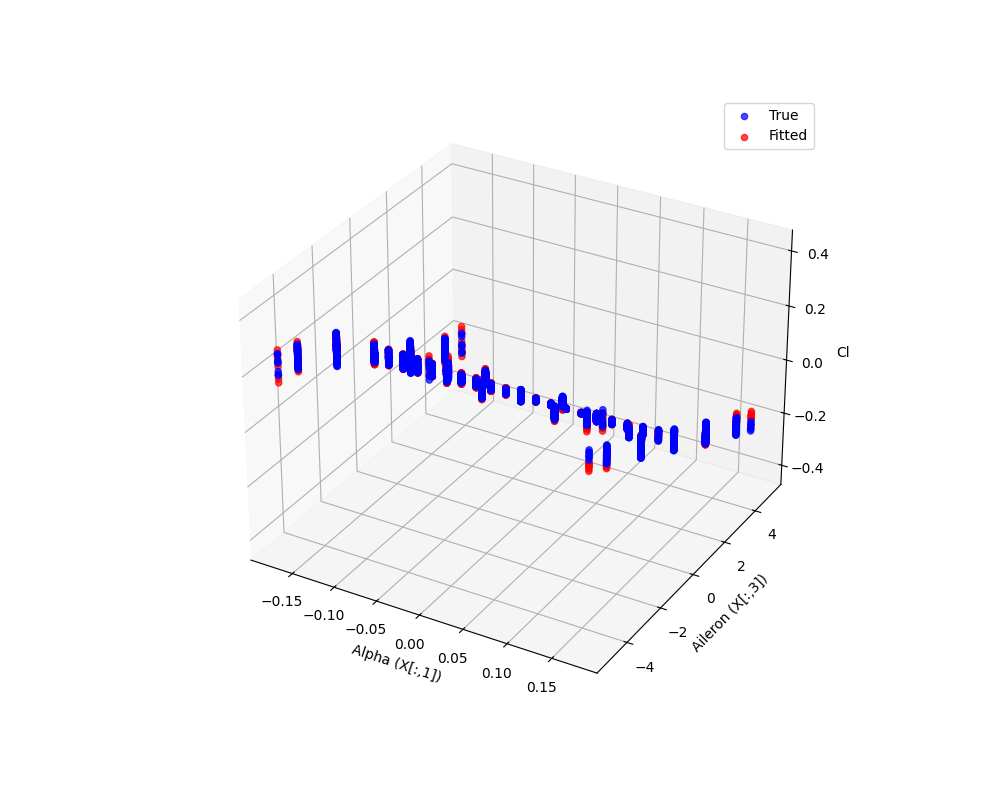

In [16]:
from mpl_toolkits.mplot3d import Axes3D
plt.ion()
%matplotlib ipympl

output_to_plot = 'Cl'
Y_true = train_data[output_to_plot].values
Y_fitted = casadi_functions[output_to_plot](X.T).full().flatten()

# Extract true and fitted values
Y_true = train_data[output_to_plot].values
Y_fitted = casadi_functions[output_to_plot](X.T).full().flatten()

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter true and fitted values over alpha and beta
ax.scatter(X[:, 1], X[:, 3], Y_true, label='True', color='b', alpha=0.7)
ax.scatter(X[:, 1], X[:, 3], Y_fitted, label='Fitted', color='r', alpha=0.7)

# Add labels and legend
ax.set_xlabel('Alpha (X[:,1])')
# ax.set_ylabel('Beta (X[:,2])')
ax.set_ylabel('Aileron (X[:,3])')
ax.set_zlabel(output_to_plot)
ax.legend()

plt.show()


In [22]:
pip install ipympl

Note: you may need to restart the kernel to use updated packages.
